# Stage 5 - Validation on ANLI/Q-Test/HAN, Experiments
- due 9/15
- parse ANLI/HAN
- Q-Test generator(This may be required earlier)

# Stage 6 - Paper Fixing (due 9/19, EACL due 9/20)

# Now Work, Todo
- reader to add bidirectional relation
    - add add_edge for simplicity
- GraphEMbeddingNet(GraphPair2VecEncoder)
    - todo
- Config is modified
    - remove or transformer embedder
    - can train on token embedding first (quicker and see effect)
    - also a must do exp
- add raw_text_datareader
- tensor_op
    - move sparse cross attention to tensor_op

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%pwd

'/work/2020-IIS-NLU-internship/MNLI/tests'

In [3]:
import os, sys
sys.path.append(os.path.abspath(".."))

# External Dependencies

In [4]:
## util
import os
import logging
from argparse import ArgumentParser
from tqdm import tqdm_notebook as tqdmnb
from tqdm import tqdm as tqdm
import pickle
import json 
import jsonlines as jsonl
from collections import defaultdict
from typing import Iterable, List, Dict, Tuple, Union
from pathlib import Path
## graph
import networkx as nx
import matplotlib.pyplot as plt
# geometric
import torch_geometric
## nn
import numpy as np
import torch
from torch_geometric.utils.convert import to_networkx
from torch_geometric.data.data import Data
## Stanza
import stanza
from stanza.models.common.doc import Document
from stanza.pipeline.core import Pipeline
## allennlp model
from allennlp_models.structured_prediction.predictors.srl import SemanticRoleLabelerPredictor
from allennlp_models.structured_prediction.predictors.biaffine_dependency_parser import BiaffineDependencyParserPredictor
from allennlp.predictors.predictor import Predictor #
## allennlp
from allennlp.data import Token, Vocabulary, Instance
from allennlp.data.fields import ListField, TextField, Field
from allennlp.data.token_indexers import (
    SingleIdTokenIndexer,
    TokenCharactersIndexer,
    ELMoTokenCharactersIndexer,
    PretrainedTransformerIndexer,
    PretrainedTransformerMismatchedIndexer,
)
from allennlp.data import DatasetReader, DataLoader, Instance, Vocabulary, PyTorchDataLoader
from allennlp.data.tokenizers import (
    CharacterTokenizer,
    PretrainedTransformerTokenizer,
    SpacyTokenizer,
    WhitespaceTokenizer,
)
from allennlp.modules.seq2vec_encoders import CnnEncoder
from allennlp.modules.text_field_embedders import BasicTextFieldEmbedder
from allennlp.modules.token_embedders import (
    Embedding,
    TokenCharactersEncoder,
    ElmoTokenEmbedder,
    PretrainedTransformerEmbedder,
    PretrainedTransformerMismatchedEmbedder,
)
from allennlp.nn import util as nn_util

# Internal Dependencies

In [6]:
import src.config as config

from src.data_git import utils as utils
from src.data_git import reader as reader

from src.models import SynNLIModel

In [7]:
# use relative by concatting pwd
# or the cahce file name will be ..SLASH........
bert_model = "bert-base-uncased"
train_data_path = "/work/2020-IIS-NLU-internship/MNLI/data/anli_v1.0/R1/train.jsonl"
validation_data_path = "/work/2020-IIS-NLU-internship/MNLI/data/anli_v1.0/R1/dev.jsonl"
test_data_path = "/work/2020-IIS-NLU-internship/MNLI/data/anli_v1.0/R1/test.jsonl"
cache_data_dir = "/work/2020-IIS-NLU-internship/MNLI/data/ANLI_instance_cache/R1"

# Read from ANLI preprocessed

In [8]:
rdr2 = reader.NLIGraphReader(input_fields=reader.config.default_fields, lazy=False, max_instances=100)

In [9]:
dev2 = rdr2.read(file_path="../data/anli_v1.0_preprocessed/R2/dev.jsonl")

# Batch Testing Model

In [10]:
vocab = Vocabulary.from_instances(dev2, min_count={"edge_labels":500}, max_vocab_size={"edge_labels":20}, non_padded_namespaces= ["*tags", "labels"]) # need to use @@unlown@@ for edge labels
# min_count={"edge_labels":150} => 58
# min_count={"edge_labels":500} => 46
# min_count={"edge_labels":1000} => 42
# 1200 => 36

In [11]:
dev2.index_with(vocab)

In [12]:
loader2 = PyTorchDataLoader(dev2, batch_size=2)

In [13]:
batch = next(iter(loader2))

In [14]:
vocab

Vocabulary with namespaces:  edge_labels, Size: 10 || labels, Size: 3 || tags, Size: 30522 || Non Padded Namespaces: {'labels', '*tags'}

# TODO now, GraphMatchingNet

In [15]:
dim_encoder = 300
dim_embedder = 768
dim_matching = 44

In [16]:
from src.modules import *

In [17]:
Graph2GraphEncoder.list_available()

['gat', 'rgcn', 'hgt']

In [18]:
GraphPair2GraphPairEncoder.list_available()

['bimpm']

In [19]:
Graph2VecEncoder.list_available()

['global_attention']

In [20]:
GraphPair2VecEncoder.list_available()

['graph_embedding_net', 'graph_matching_net']

In [21]:
batch["g_p"].keys()

dict_keys(['edge_index', 'edge_attr', 'batch_id'])

In [22]:
transformer_embedder = PretrainedTransformerMismatchedEmbedder(model_name=config.TRANSFORMER_NAME)

In [23]:
gate_nn = torch.nn.Linear(300, 1)
node_nn = torch.nn.Linear(300, 300)

In [24]:
pooler = Graph2VecEncoder.by_name("global_attention")(gate_nn=gate_nn, nn=node_nn)
pooler

GlobalAttention(gate_nn=Linear(in_features=300, out_features=1, bias=True), nn=Linear(in_features=300, out_features=300, bias=True))

In [25]:
rgcn = Graph2GraphEncoder.by_name("rgcn")(
    in_channels=300,
    out_channels=300,
    aggr="add",
    num_relations=20,
    root_weight=False,
    bias=False,
)
print(rgcn)
"""
"in_dim" : 300
"out_dim" : 300
"num_types" : 10
"num_relations" : 20
"n_heads" : 5
"dropout" : 0.2
"use_norm" : true
"use_RTE" : false
"""
ght = Graph2GraphEncoder.by_name("hgt")(
    in_dim=300,
    out_dim=300,
    num_relations=20,
    num_types=1,
    n_heads=5,
    use_RTE=False,
    use_norm=True,
)
print(ght)

RGCNConv(300, 300, num_relations=20)
HGTConv(in_dim=300, out_dim=300, num_types=1, num_types=20)


In [26]:
#gen = GraphPair2VecEncoder.by_name("graph_matching_net")(convs=rgcn, num_layers=3, pooler=pooler) # this is a constructor
#gen

In [27]:
from allennlp.modules.bimpm_matching  import BiMpmMatching#from allennlp.common  import Params
from allennlp.common import Params

match = BiMpmMatching.from_params(
    params = Params({
        "hidden_dim" : 300,
        "num_perspectives" : 10,
        "share_weights_between_directions" : False,
        "with_full_match" : False,
        "with_maxpool_match" :  True,
        "with_attentive_match" : True,
        "with_max_attentive_match" : True,
    })
)



In [28]:
from src.modules.graph_pair2graph_pair_encoders.graph_pair_mpm import GraphPairMPM
graph_bimpm = GraphPairMPM(bimpm=match)
graph_bimpm._dim_match

44

In [29]:
upd = NodeUpdater.by_name("gru")(input_size=dim_encoder+graph_bimpm._dim_match, hidden_size=dim_encoder)

In [30]:
from allennlp.modules import FeedForward
from allennlp.nn import Activation
projector = FeedForward(768, 1, 300, Activation.by_name("linear")(), 0.0)
classifier = FeedForward(300*4, 2, [300, 3], Activation.by_name("relu")(), 0.0)

In [31]:
gmn = GraphPair2VecEncoder.by_name("graph_matching_net")(
    num_layers = 3,
    convs = rgcn, 
    atts = graph_bimpm,
    updater = upd,  
    pooler =  pooler,
)

In [32]:
#print(model._modules) # no encoder of GraphMatchingNet
print(isinstance(gmn, torch.nn.Module))

True


In [33]:
model = SynNLIModel(
    vocab=vocab,
    embedder=transformer_embedder,
    projector=projector,
    encoder=gmn,
    classifier=classifier,
)

In [34]:
model(**batch)

{'probs': tensor([[0.3319, 0.3242, 0.3439],
         [0.3317, 0.3224, 0.3459]], grad_fn=<SoftmaxBackward>),
 'loss': tensor(1.1291, grad_fn=<NllLossBackward>)}

In [35]:
model.get_metrics(reset=True)

{'accuracy': 0.0, 'entropy': 1.0982556343078613}

In [36]:
%pwd

'/work/2020-IIS-NLU-internship/MNLI/tests'

In [37]:
import pickle
with open("../b.pkl", "rb") as fo:
    ba = pickle.load(fo)

In [514]:
model(**ba)

{'probs': tensor([[0.3322, 0.3259, 0.3419],
         [0.3338, 0.3268, 0.3394],
         [0.3325, 0.3267, 0.3408],
         [0.3350, 0.3251, 0.3399],
         [0.3347, 0.3257, 0.3396],
         [0.3335, 0.3264, 0.3400],
         [0.3331, 0.3265, 0.3404],
         [0.3334, 0.3262, 0.3404],
         [0.3310, 0.3256, 0.3434],
         [0.3329, 0.3254, 0.3417],
         [0.3316, 0.3261, 0.3423],
         [0.3313, 0.3259, 0.3428],
         [0.3331, 0.3258, 0.3411],
         [0.3329, 0.3266, 0.3405],
         [0.3332, 0.3255, 0.3414],
         [0.3332, 0.3255, 0.3413]], grad_fn=<SoftmaxBackward>),
 'loss': tensor(1.0994, grad_fn=<NllLossBackward>)}

In [39]:

print(ba["tokens_p"]["tokens"].keys())
print(
    ba["tokens_p"]["tokens"]["token_ids"].size(),
    ba["tokens_p"]["tokens"]["wordpiece_mask"].size(),
    ba["tokens_p"]["tokens"]["type_ids"].size(),
    ba["tokens_p"]["tokens"]["offsets"].size(),
    ba["tokens_p"]["tokens"]["mask"].size()
)

dict_keys(['token_ids', 'mask', 'type_ids', 'wordpiece_mask', 'offsets'])
torch.Size([16, 107]) torch.Size([16, 107]) torch.Size([16, 107]) torch.Size([16, 87, 2]) torch.Size([16, 87])


In [40]:
loader2.batch_size

2

# Test GPU device can use

In [41]:
def recursive_to_device(data, device):
    for k in data.keys():
        if isinstance(data[k], dict):
            recursive_to_device(data[k], device)
        else:
            data[k] = data[k].to(device)

In [42]:
recursive_to_device(batch, "cuda")

KeyboardInterrupt: 

In [ ]:
model.to("cuda")

In [520]:
model(**batch)

{'probs': tensor([[0.3319, 0.3242, 0.3439],
         [0.3317, 0.3224, 0.3459]], grad_fn=<SoftmaxBackward>),
 'loss': tensor(1.1291, grad_fn=<NllLossBackward>)}

In [43]:
for n in model.to("cpu").named_parameters():
    if n[:7] == "encoder":
        print(n)

# Predictor

In [ ]:
from src.data_git.reader import NLIGraphReader
nlp = stanza.Pipeline(lang='en', processors='tokenize,mwt,pos,lemma,depparse')
rdr_nlp = NLIGraphReader(
        wordpiece_tokenizer = None,
        token_indexers = None,
        combine_input_fields = None,
        input_parsed  = False,
        parser = nlp,
        input_fields = None,
)

In [586]:
from src.predictors import GraphNLIPredictor

In [587]:
del predictor
predictor = GraphNLIPredictor(model = model, dataset_reader=rdr_nlp)

In [591]:
predictor.predict_json(
{
    "sentence1": "Allen is smart.",
    "sentence2" : "Allen is stupid.",
    "gold_label": "c",
})
# to be done, need to pass nlp some where

{'probs': [0.3340727388858795, 0.32438600063323975, 0.3415412902832031],
 'loss': 1.074286699295044,
 'predicted_label': 'c'}

In [592]:
print(predictor.predict_instance(dev2[0]))

{'probs': [0.33190587162971497, 0.32423725724220276, 0.3438568413257599], 'loss': 1.126279592514038, 'predicted_label': 'c'}


In [593]:
predictor.predict_batch_instance([dev2[0], dev2[1]])

[{'probs': [0.33190590143203735, 0.32423725724220276, 0.3438568413257599],
  'predicted_label': 'c'},
 {'probs': [0.33165624737739563, 0.32240569591522217, 0.3459380567073822],
  'predicted_label': 'c'}]

# Attention Visualizer

In [394]:
print(model(**batch, return_attention = True)["attentions"]["pooler1"][0].size())

torch.Size([1, 68])


In [395]:
att = model(**batch, return_attention = True)["attentions"]["pooler2"]

In [396]:
batch["tokens_p"]["tokens"]["token_ids"].size()

torch.Size([2, 84])

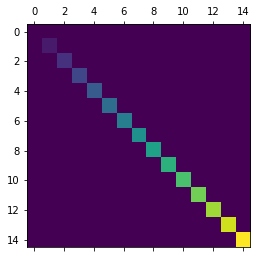

In [397]:
def samplemat(dims):
    """Make a matrix with all zeros and increasing elements on the diagonal"""
    aa = np.zeros(dims)
    for i in range(min(dims)):
        aa[i, i] = i
    return aa


# Display matrix
plt.matshow(samplemat((15, 15)))

plt.show()

In [577]:
str1p = [ token.text for token in  dev2[0].fields["tokens_p"].tokens]
str1h = [ token.text for token in  dev2[0].fields["tokens_h"].tokens]

In [399]:
rdr2.instance2sent(dev2[0])

{'premise': '$ Clear Hearts Grey Flowers is the second full - length and final album by Jack Off Jill . $ Produced by Chris Vrenna of Nine Inch Nails / Tweaker , it was released in July 2000 on the now - defunct label Risk Records . $ After " Clear Hearts , Grey Flowers " the band formally split up and moved on to establish other projects .',
 'hypothesis': "$ Risk Records released Jack Off Jill 's initial album ."}

In [400]:
from src.interpret import (
    show_sequence_attention,
    show_matrix_attention
)

In [401]:
att[0]

tensor([[0.0890, 0.0916, 0.0971, 0.1049, 0.0949, 0.0808, 0.0825, 0.0893, 0.0890,
         0.0915, 0.0895]])

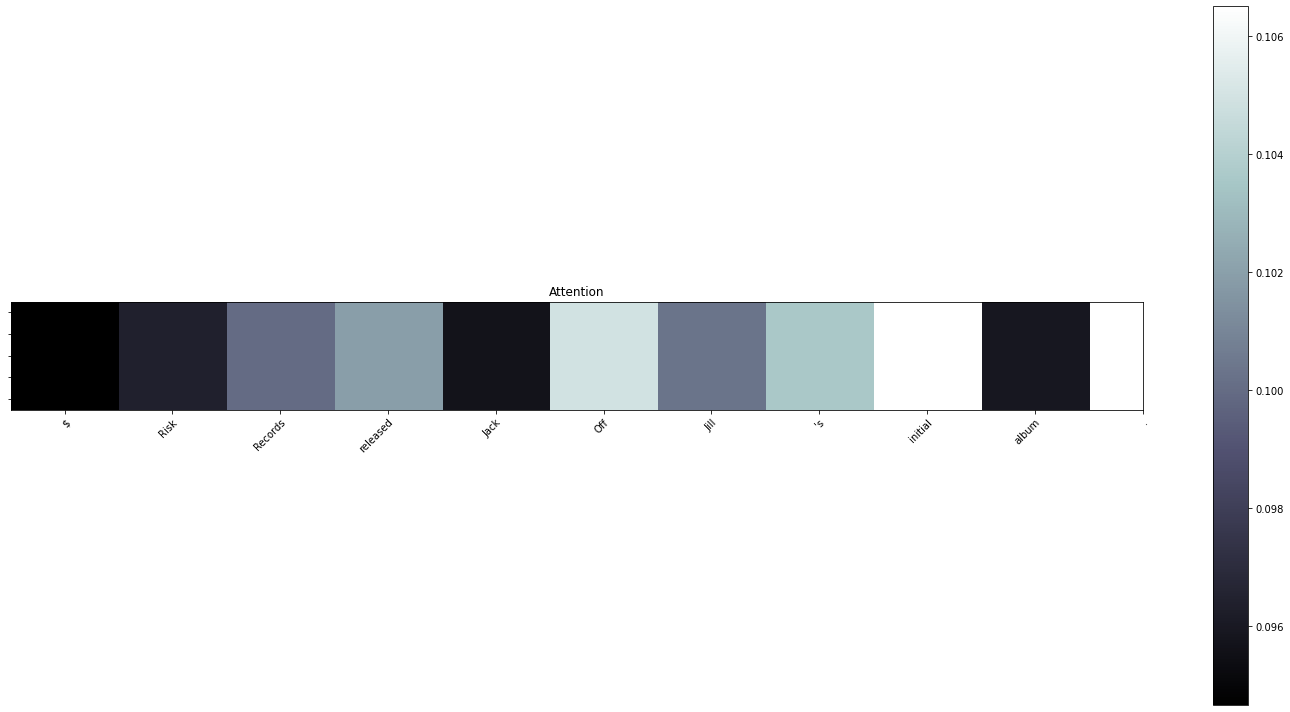

In [582]:
show_sequence_attention(strlist, att[1])

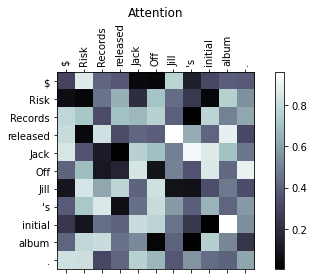

In [404]:
show_matrix_attention(strlist, strlist, torch.rand(11,11))

# Model Loading + Demo

In [405]:
jdata = json.loads('{"d":4}')

In [406]:
type(jdata)

dict

In [534]:
serialization_dir = "../param/GMN_BERT_300d_/"

In [540]:
from allennlp.common import Params
lm_config = Params.from_file(serialization_dir+"config.json")
lm_config

In [541]:
#lm = Model.from_archive("../param
lm = Model.load(
    config = lm_config,
    serialization_dir = serialization_dir,
    weights_file = None, # use best by default
    cuda_device = -1
) 

In [543]:
lm_vocab = lm.vocab
lm_vocab

Vocabulary with namespaces:  edge_labels, Size: 22 || labels, Size: 3 || Non Padded Namespaces: {'labels'}

In [545]:
predictor_load = GraphNLIPredictor(model = lm, dataset_reader=rdr_nlp)

In [579]:
att1h = lm(**batch, return_attention=True)["attentions"]["pooler2"][0]

In [580]:
att1p = lm(**batch, return_attention=True)["attentions"]["pooler1"][0]

In [574]:
dev2[0]

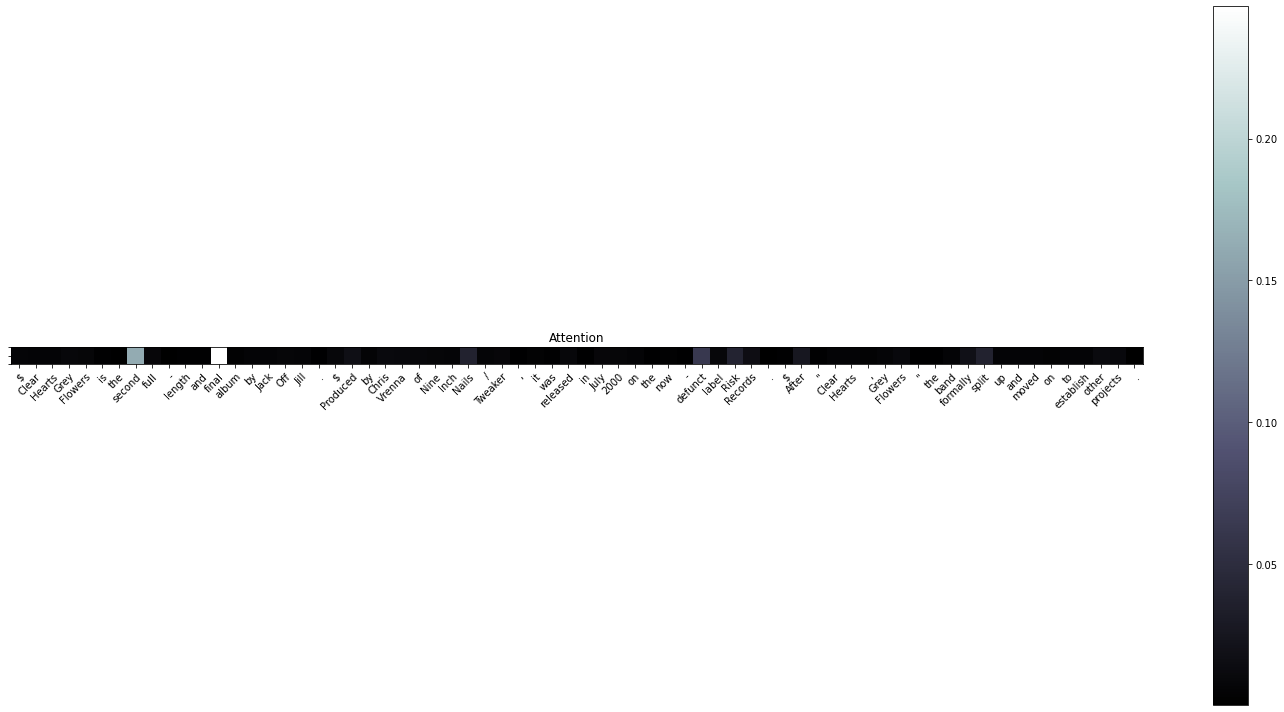

In [583]:
show_sequence_attention(str1p, att1p)

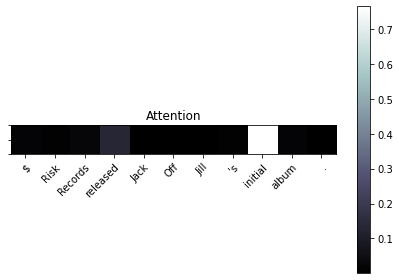

In [578]:
show_sequence_attention(str1h, att1p)

In [555]:
def print_inst(inst):
    print(
        inst.fields["tokens_p"],
        inst.fields["tokens_h"],
        inst.fields["label"],
        sep='\n',
        )
print_inst(dev2[0])

TextField of length 68 with text: 
 		[$, Clear, Hearts, Grey, Flowers, is, the, second, full, -, length, and, final, album, by, Jack,
		Off, Jill, ., $, Produced, by, Chris, Vrenna, of, Nine, Inch, Nails, /, Tweaker, ,, it, was,
		released, in, July, 2000, on, the, now, -, defunct, label, Risk, Records, ., $, After, ", Clear,
		Hearts, ,, Grey, Flowers, ", the, band, formally, split, up, and, moved, on, to, establish, other,
		projects, .]
 		and TokenIndexers : {'tokens': 'PretrainedTransformerMismatchedIndexer'}
TextField of length 11 with text: 
 		[$, Risk, Records, released, Jack, Off, Jill, 's, initial, album, .]
 		and TokenIndexers : {'tokens': 'PretrainedTransformerMismatchedIndexer'}
LabelField with label: n in namespace: 'labels'.'


In [547]:
predictor_load.predict_batch_instance([dev2[0], dev2[1]]) # can return label(after modify code!)

[{'probs': [0.2452898621559143, 0.4792807102203369, 0.2754293978214264],
  'label': 'contradiction'},
 {'probs': [0.1516234427690506, 0.4691127836704254, 0.3792637884616852],
  'label': 'contradiction'}]

In [ ]:
# two ways for model loading 
# params of config + .th

"""
components = run_config(CONFIG)
params = components['params']
dataset_reader = components['dataset_reader']
vocab = components['vocab']
model = components['model']


original_preds = make_predictions(model, dataset_reader)

# Save the model
serialization_dir = 'model'
config_file = os.path.join(serialization_dir, 'config.json')
vocabulary_dir = os.path.join(serialization_dir, 'vocabulary')
weights_file = os.path.join(serialization_dir, 'weights.th')

os.makedirs(serialization_dir, exist_ok=True)
params.to_file(config_file)
vocab.save_to_files(vocabulary_dir)
torch.save(model.state_dict(), weights_file)

# Load the model
loaded_params = Params.from_file(config_file)
loaded_model = Model.load(loaded_params, serialization_dir, weights_file)
loaded_vocab = loaded_model.vocab   # Vocabulary is loaded in Model.load()

# Make sure the predictions are the same
loaded_preds = make_predictions(loaded_model, dataset_reader)
assert original_preds == loaded_preds
print('predictions matched')

# Create an archive file
archive_model(serialization_dir, weights='weights.th')

# Unarchive from the file
archive = load_archive(os.path.join(serialization_dir, 'model.tar.gz'))

# Make sure the predictions are the same
archived_preds = make_predictions(archive.model, dataset_reader)
assert original_preds == archived_preds
print('predictions matched')
"""